In [1]:
import tensorflow as tf
import pathlib

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE


In [3]:
data_root_orig = '../input/train_images'


In [4]:
data_root_orig

'../input/train_images'

In [5]:
data_root = pathlib.Path(data_root_orig)

In [6]:
data_root

PosixPath('../input/train_images')

In [7]:
import random
all_image_paths = list(data_root.glob('./*'))

In [8]:
import pandas as pd

train_labels = pd.read_csv("../input/train_images.csv")


In [9]:
train_labels.head()

,id,class_num
0,train_0000.jpg,0
1,train_0001.jpg,0
2,train_0002.jpg,0
3,train_0003.jpg,0
4,train_0004.jpg,0


In [10]:
all_image_paths = [str(path) for path in all_image_paths]

image_count = len(all_image_paths)


In [11]:
image_count

1102

In [12]:
train_labels.describe()

,class_num
count,1102.000000
mean,1.235027
std,1.136516
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,3.000000


In [13]:
import IPython.display as display
import random

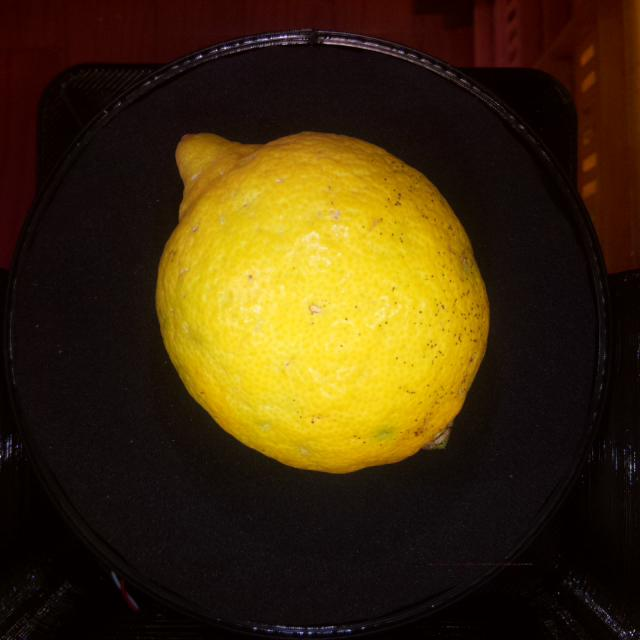

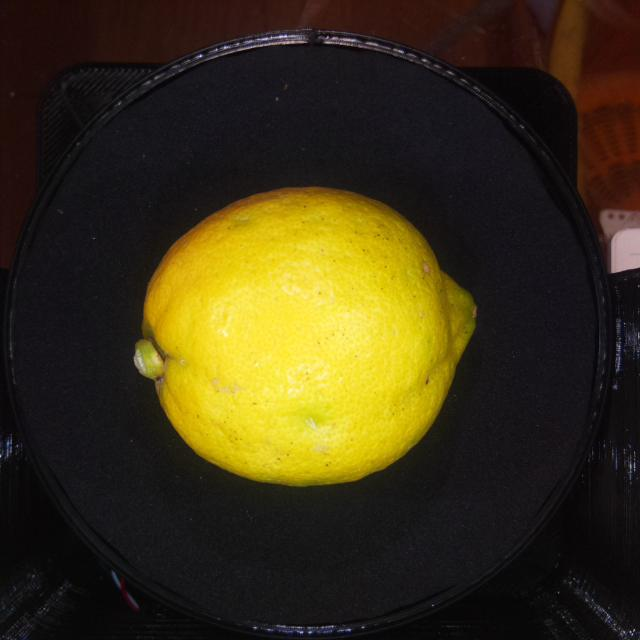

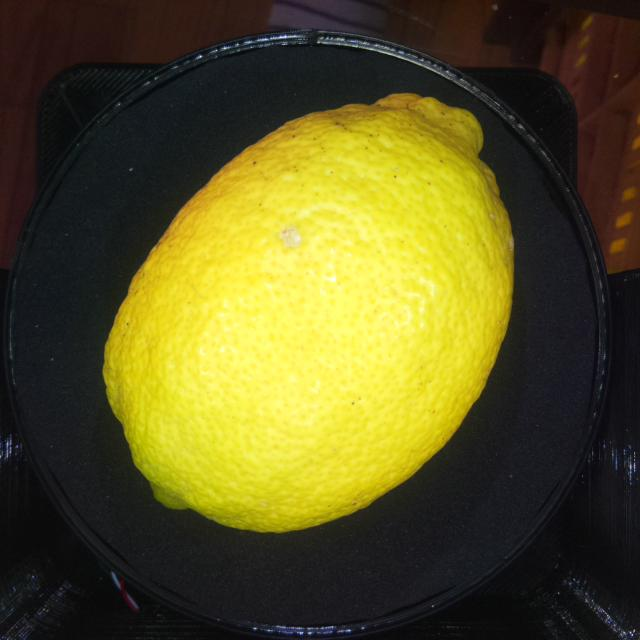

In [14]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))

In [15]:
all_image_paths.sort()

In [16]:
img_path = all_image_paths[0]

In [17]:
img_path

'../input/train_images/train_0000.jpg'

In [18]:
img_raw = tf.io.read_file(img_path)

In [19]:
img_tensor = tf.image.decode_image(img_raw)

In [20]:
img_tensor.shape

TensorShape([640, 640, 3])

In [21]:
img_tensor.dtype

tf.uint8

In [22]:
img_final = tf.image.resize(img_tensor, [192,192])
img_final = img_final/255.0

In [23]:
img_final.shape

TensorShape([192, 192, 3])

In [24]:
img_final.numpy().min()

0.0

In [25]:
img_final.numpy().max()

1.0

In [26]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192,192])
    image /= 255.0
    
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)


In [27]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = train_labels['class_num'][0]

In [28]:
label_to_index = {'excellent':0, 'good': 1, 'normal':2, 'bad':3}

In [29]:
label_names = ['excellent', 'good', 'normal', 'bad']

In [30]:
image_path = all_image_paths[0]

In [31]:
image_path

'../input/train_images/train_0000.jpg'

Text(0.5, 1.0, 'Excellent')

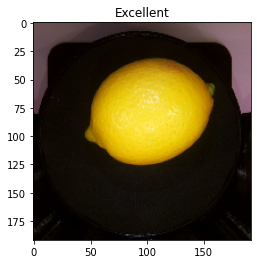

In [32]:
plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
plt.title(label_names[label].title())


In [33]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)


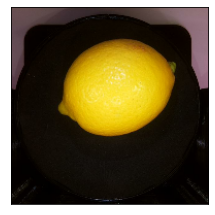

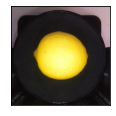

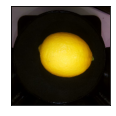

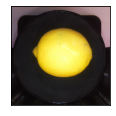

In [34]:
plt.figure(figsize=(8,8))

for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [35]:
all_labels = train_labels['class_num']

In [36]:
all_labels

0       0
1       0
2       0
3       0
4       0
       ..
1097    1
1098    0
1099    1
1100    2
1101    0
Name: class_num, Length: 1102, dtype: int64

In [37]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_labels, tf.int64))


In [38]:
for label in label_ds.take(20):
    print(label_names[label.numpy()])

excellent
excellent
excellent
excellent
excellent
good
good
normal
bad
bad
good
normal
bad
excellent
excellent
excellent
excellent
excellent
excellent
good


In [39]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [40]:
image_label_ds

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>

In [41]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_labels))

In [42]:
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

In [43]:
image_label_ds = ds.map(load_and_preprocess_from_path_label)

In [44]:
image_label_ds

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>

In [45]:
BATCH_SIZE = 32

ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)


In [68]:
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>

In [46]:
ds = image_label_ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)


Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


In [47]:
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>

In [52]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192,192,3), include_top=False)
mobile_net.trainable = False


In [53]:
def change_range(image, label):
    return 2*image-1, label



In [54]:
keras_ds = ds.map(change_range)
image_batch, label_batch = next(iter(keras_ds))


In [55]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)


(32, 6, 6, 1280)


In [56]:
model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(4)
])


In [57]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max Ligit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)


min logit: -1.3694003
max Ligit: 1.4011223

Shape: (32, 4)


In [58]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [59]:
len(model.trainable_variables)

2

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [61]:
steps_per_epoch = tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch


35.0

In [62]:
model.fit(ds, epochs=1, steps_per_epoch=3)

3/3 [==============================] - 2s 715ms/step - loss: 6.3602 - accuracy: 0.3125
